In [1]:
print "Sample Notebook using AskUbuntu User Data."

Sample Notebook using AskUbuntu User Data.


In [2]:
print "All imports go in this cell."

import pyspark.sql.functions as func
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
%matplotlib inline

All imports go in this cell.


In [3]:
print "Check if SparkContext and SQLContext has been created."
print sc
sqlContext = SQLContext(sc)
print sqlContext

Check if SparkContext and SQLContext has been created.


In [4]:
print "Load AskUbuntu User Data and cache it."
dataPath = "../data/AskUbuntu/User"
auDF = sqlContext.read.load(dataPath).cache()

Load AskUbuntu User Data and cache it.


In [5]:
print "Total number of rows in the data = " + str(auDF.count())
print "Schema for user data:"
auDF.printSchema()

Total number of rows in the data = 309295
Schema for user data:
root
 |-- Id: long (nullable = true)
 |-- Reputation: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- EmailHash: string (nullable = true)
 |-- lastAccessDate: string (nullable = true)
 |-- WebsiteUrl: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- AboutMe: string (nullable = true)
 |-- Views: long (nullable = true)
 |-- UpVotes: long (nullable = true)
 |-- DownVotes: long (nullable = true)
 |-- AccountId: long (nullable = true)



In [6]:
print "Before using any algorithm from mllib, we transform this data to a collection of vectors."
print "We filter for certain values that we used as default values (in place of missing values) while parsing \
the xml file."
vectorData = auDF.filter("AccountId > -1 and DownVotes > -1 and UpVotes > -1 and Age > -1 \
and Reputation > -9223372036854775808").select("Age", "Reputation", "UpVotes", "DownVotes")\
.map(lambda data: Vectors.dense([c for c in data]))
print "This vectorData consists of rows, where each row is a vector of data we selected above."
vectorData.take(5)

Before using any algorithm from mllib, we transform this data to a collection of vectors.
We filter for certain values that we used as default values (in place of missing values) while parsing the xml file.
This vectorData consists of rows, where each row is a vector of data we selected above.


[DenseVector([34.0, 1.0, 0.0, 0.0]),
 DenseVector([21.0, 101.0, 1.0, 0.0]),
 DenseVector([24.0, 23.0, 3.0, 0.0]),
 DenseVector([29.0, 1.0, 0.0, 0.0]),
 DenseVector([36.0, 54.0, 0.0, 0.0])]

In [7]:
print "Now we can calculate correlation between each pair of columns and see if we find some thing interesting."
print(Statistics.corr(vectorData, method="pearson"))

Now we can calculate correlation between each pair of columns and see if we find some thing interesting.
[[ 1.          0.02262138  0.0164091   0.00365094]
 [ 0.02262138  1.          0.55932768  0.18192911]
 [ 0.0164091   0.55932768  1.          0.26070515]
 [ 0.00365094  0.18192911  0.26070515  1.        ]]


In [8]:
print "Notice the high positive correlation between Reputation and Upvotes."
print "Lets drill down further."

Notice the high positive correlation between Reputation and Upvotes.
Lets drill down further.


In [9]:
print "We filter the data to contain only Reputation and UpVotes and filter for rows with defualt values"
data = auDF.filter("AccountId > -1 and UpVotes > -1 and Reputation > -9223372036854775808")\
    .select("Reputation", "UpVotes").cache()
data.describe().show()

We filter the data to contain only Reputation and UpVotes and filter for rows with defualt values
+-------+-----------------+----------------+
|summary|       Reputation|         UpVotes|
+-------+-----------------+----------------+
|  count|           309284|          309284|
|   mean|54.91940417221712| 3.9326023977962|
| stddev|691.1368882991297|83.5654785486054|
|    min|                1|               0|
|    max|           150176|           24318|
+-------+-----------------+----------------+



In [10]:
print "Notice that this is the second dataframe that we have cached so far. \
We can check the memory profile for the app at http://localhost:4040/storage."
print "We no longer need the auDF so we will unpersist it and recover some memory."
auDF.unpersist()
print "Check that now only one dataframe is cached for the application. http://localhost:4040/storage."

Notice that this is the second dataframe that we have cached so far. We can check the memory profile for the app at http://localhost:4040/storage.
We no longer need the auDF so we will unpersist it and recover some memory.
Check that now only one dataframe is cached for the application. http://localhost:4040/storage.


Spark is good when it comes to computation but not so good at visualisations.Pandas is good at handling in-memory computations and Pandas dataframes can be visualised easily. So we will load a sample of the dataset into Pandas dataframe using the toPandas method.


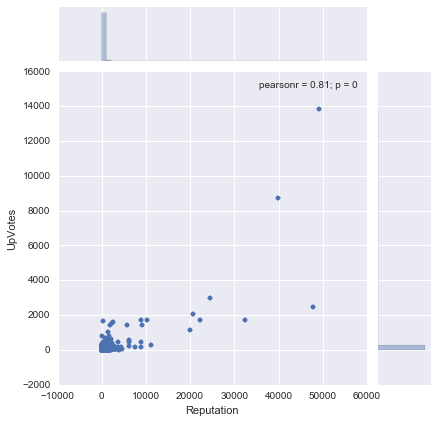

In [11]:
print "Spark is good when it comes to computation but not so good at visualisations.\
Pandas is good at handling in-memory computations and Pandas dataframes can be visualised easily. \
So we will load a sample of the dataset into Pandas dataframe using the toPandas method."
pandasDF = data.sample(False, .1).toPandas()
sns.jointplot('Reputation', 'UpVotes', data=pandasDF)

This visualistion is unintutive as most of the data is distributed in a narrow zone and the scale is skewed due to outliers. We will plot the values on the log scale.
Now the plot looks much better.


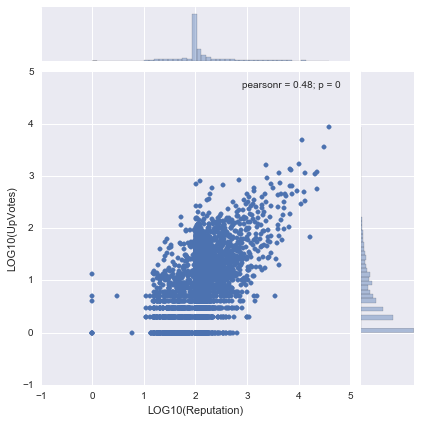

In [12]:
print "This visualistion is unintutive as most of the data is distributed in a narrow zone and the \
scale is skewed due to outliers. We will plot the values on the log scale."
logPandasDF = data.select(func.log10(data["Reputation"]), func.log10(data["UpVotes"])).sample(False, .1).toPandas()
sns.jointplot('LOG10(Reputation)', 'LOG10(UpVotes)', data=logPandasDF)
print "Now the plot looks much better."

In [13]:
print "We will now play with the CreationDate column now."
creationDateDF = sqlContext.read.load(dataPath).select("CreationDate").cache()
creationDateDF.printSchema()
creationDateDF.show()

We will now play with the CreationDate column now.
root
 |-- CreationDate: string (nullable = true)

+--------------------+
|        CreationDate|
+--------------------+
|2014-12-29T00:50:...|
|2014-12-29T00:52:...|
|2014-12-29T01:00:...|
|2014-12-29T01:04:...|
|2014-12-29T01:13:...|
|2014-12-29T01:15:...|
|2014-12-29T02:03:...|
|2014-12-29T02:05:...|
|2014-12-29T02:25:...|
|2014-12-29T02:37:...|
|2014-12-29T03:03:...|
|2014-12-29T03:14:...|
|2014-12-29T03:21:...|
|2014-12-29T03:25:...|
|2014-12-29T03:38:...|
|2014-12-29T03:44:...|
|2014-12-29T04:25:...|
|2014-12-29T04:29:...|
|2014-12-29T04:30:...|
|2014-12-29T04:48:...|
+--------------------+
only showing top 20 rows



In [14]:
print "Note that date was parsed as string. Let us transform it to dateType. \
For that, we select CreationDate as *date* value."
dateDF = creationDateDF.select(func.to_date(creationDateDF["CreationDate"]).alias("CreationDate"))
dateDF.show()
dateDF.printSchema()

Note that date was parsed as string. Let us transform it to dateType. For that, we select CreationDate as *date* value.
+------------+
|CreationDate|
+------------+
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
|  2014-12-29|
+------------+
only showing top 20 rows

root
 |-- CreationDate: date (nullable = true)



In [15]:
print "Now we want to count the number of new accounts each day."
tempDF = dateDF.map(lambda a: (a, 1)).reduceByKey(lambda a, b: a+b).toDF()
print "tempDF maps each date to number of accounts that were created."
tempDF.printSchema()
print "Notice that we have lost the column names and that our date column is converted into a struct column. \
Let us fix these things and sample some data into Pandas dataframe."

Now we want to count the number of new accounts each day.
tempDF maps each date to number of accounts that were created.
root
 |-- _1: struct (nullable = true)
 |    |-- CreationDate: date (nullable = true)
 |-- _2: long (nullable = true)

Notice that we have lost the column names and that our date column is converted into a struct column. Let us fix these things and sample some data into Pandas dataframe.


In [16]:
pandasDF = tempDF.select(tempDF["_1"].getField("CreationDate").alias("CreationDate"), tempDF["_2"].alias("NewAccounts"))\
.orderBy(func.asc("CreationDate")).toPandas()
pandasDF

,CreationDate,NewAccounts
0,2010-07-28,154
1,2010-07-29,64
2,2010-07-30,8
3,2010-07-31,3
4,2010-08-02,12
5,2010-08-03,16
6,2010-08-04,147
7,2010-08-05,181
8,2010-08-06,74
9,2010-08-07,29


Let us plot this data and see if there is any interesting observation.


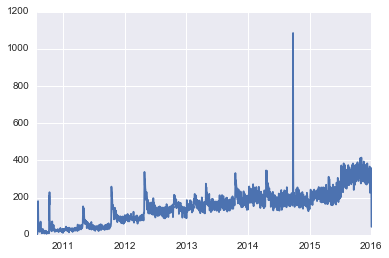

In [17]:
print "Let us plot this data and see if there is any interesting observation."
plt.plot(pandasDF.CreationDate, pandasDF.NewAccounts)

In [18]:
print "Interesting! We can see a spike. If we zoom into the data, we see the date of the spike as \
25th September,2014 when around 1080 new users joined AskUbuntu."
print "To open the plot in interactive mode, uncomment the code below and run the cell again."
# %matplotlib qt
# plt.plot(pandasDF.CreationDate, pandasDF.NewAccounts)

Interesting! We can see a spike. If we zoom into the data, we see the date of the spike as 25th September,2014 when around 1080 new users joined AskUbuntu.
To open the plot in interactive mode, uncomment the code below and run the cell again.


In [19]:
print "What else can we do with this data? \
Maybe plot all the users on Google Maps or use the email hashes to relate user activity across the \
StackExchange Network."

What else can we do with this data? Maybe plot all the users on Google Maps or use the email hashes to relate user activity across the StackExchange Network.
